In [1]:
import sys
import os
import json
import tensorflow as tf
import tqdm
from models.model import *
from ltv_utils import *
from losses.custom_loss import *
pd.set_option('display.float_format', '{:.4f}'.format)  # 保留10位小数，可调整
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)


def parse_function(serialized_example):
    feature_description = {
        'deviceid': tf.io.FixedLenFeature([], tf.string),
        'install_date': tf.io.FixedLenFeature([], tf.string),
        'dim_os_name1': tf.io.FixedLenFeature([], tf.string),
        'creative_classify1': tf.io.FixedLenFeature([], tf.string),
        'total_pay_amount1':  tf.io.FixedLenFeature([], tf.float32),
         'channel1': tf.io.FixedLenFeature([], tf.string),
        'b2_sale_amt_bias':  tf.io.FixedLenFeature([], tf.int64),
         'b2_sale_amt_7d': tf.io.FixedLenFeature([], tf.int64),
         'install_time': tf.io.FixedLenFeature([], tf.string),
        'install_order_diff':  tf.io.FixedLenFeature([], tf.int64),
        'all_install_order_7d_diff':  tf.io.FixedLenFeature([], tf.int64),
        'is_a1x_a33':  tf.io.FixedLenFeature([], tf.int64),
        'platform_label':  tf.io.FixedLenFeature([], tf.string),
        'user_dense_price_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_price_features'])], tf.float32),
        'user_dense_duration_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_duration_features'])], tf.float32),
        'user_dense_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_features'])], tf.float32),
        'user_sparse_features': tf.io.FixedLenFeature([len(group_2_features['user_sparse_features'])], tf.float32)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    return example


# load tf records
group_2_features = read_feature_json_config('features/feature_list.json')

train_file_name = 'data/ltv_0522_0603_multi_window_model_train/part-r-00000'
valid_file_name = 'data/ltv_0522_0603_multi_window_model_valid/part-r-00000'

train_dataset, valid_dataset, _ = get_trian_valid_test_dateset(parse_function, 10000, train_file_name, valid_file_name)



user_dense_price_features = group_2_features['user_dense_price_features']
user_dense_duration_features = group_2_features['user_dense_duration_features']
user_dense_features = group_2_features['user_dense_features']
user_sparse_features = group_2_features['user_sparse_features']


2025-06-30 15:37:54.365201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-30 15:37:54.537333: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 15:37:54.543170: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-30 15:37:54.543191: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
MODEL_HOUR = 0 

In [3]:
def create_tf_dataset(dataset):
    sample_batch = next(iter(dataset))
    sample_data = {k: v for k, v in sample_batch.items() if k not in ['b2_sale_amt_7d', 'total_pay_amount1']}

    def generator():
        for batch in dataset:
            hour = tf.cast(tf.gather(batch['user_sparse_features'],  indices=0, axis = 1) - 1, tf.int64)    # shape: (batch_size,)
            b2_7d = tf.cast(tf.reshape(batch.pop('b2_sale_amt_7d'), (-1, 1)), tf.float32)
            b2_7d = tf.maximum(b2_7d, 0.0)
            
            total_amt_1h = tf.reshape(batch.pop('total_pay_amount1'), (-1, 1))

            # 只保留 hour 为 MODEL_HOUR 的记录
            hour_mask = tf.equal(hour, MODEL_HOUR)  # shape: (batch_size,)
            hour_mask = tf.reshape(hour_mask, (-1, 1))  # 广播成 (batch_size, 1)
            
            #  使用 hour_mask 筛选 batch 中的 对应小时窗口 
            selected_indices = tf.where(hour_mask)[:, 0]  # 获取 hour == 1 的样本索引
            batch = {k: tf.gather(v, selected_indices, axis=0) for k, v in batch.items()}  # 筛选 batch 中的样本
            b2_7d = tf.gather(b2_7d, selected_indices, axis=0)  # 保留 hour == 1 对应的标签

            y_true_packed = b2_7d
            
            yield batch, y_true_packed
        

    # 正确写法：output_signature 中保留每个字段的真实 shape
    output_signature = (
        {
            name: tf.TensorSpec(shape=(None,) + v.shape[1:], dtype=v.dtype)
            for name, v in sample_data.items()
        },
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

In [5]:

from tensorflow.keras import Input, Model

import tensorflow as tf


import tensorflow as tf

class TweedieLoss(tf.keras.losses.Loss):
    def __init__(self, p=1.5, name="tweedie_loss"):
        super().__init__(name=name)
        if not (1 < p < 2):
            raise ValueError(f"Tweedie loss only supports 1 < p < 2. Got p={p}")
        self.p = p

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-4, 1e4)  # 限制y_pred，防止数值爆炸
        y_true = tf.maximum(y_true, 0.0)

        term2 = tf.math.pow(y_pred, 2 - self.p) / (2 - self.p)
        term1 = y_true * tf.math.pow(y_pred, 1 - self.p) / (1 - self.p)
        loss = (term2 - term1)

        return tf.reduce_mean(loss)

        
# 构建输入层（只包含模型中用到的字段）
input_keys = ['user_dense_features', 'user_dense_price_features', 'user_dense_duration_features', 'user_sparse_features']
inputs = {
    key: Input(shape=(len(group_2_features[key]),), name=key)
    for key in input_keys
}


# 调用你自定义的特征拼接层
x = NO_Process_Layer(
    'user_dense_features',
    'user_dense_price_features',
    'user_dense_duration_features',
    'user_sparse_features'
)(inputs)
# 后续网络层
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)

# 构建模型
model = Model(inputs=inputs, outputs=output)

# 自己实现的双口loss
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 监控验证集上的 loss
    patience=3,          # 如果连续 3 轮没有改善，就停止训练
    restore_best_weights=True  # 训练结束后恢复到最优模型
)


model.compile(
    loss=TweedieLoss(p=1.5),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='rmse')
    ]
)

model.fit(
    create_tf_dataset(train_dataset),
    epochs=15,
    validation_data = create_tf_dataset(valid_dataset),
    callbacks= [early_stopping]
) 

Epoch 1/15
248/248 [==============================] - 74s 295ms/step - loss: 72.2243 - rmse: 262.0077 - val_loss: 25.4119 - val_rmse: 265.4871
Epoch 2/15
248/248 [==============================] - 72s 290ms/step - loss: 24.7277 - rmse: 241.6656 - val_loss: 25.1196 - val_rmse: 251.4153
Epoch 3/15
248/248 [==============================] - 72s 288ms/step - loss: 24.5873 - rmse: 236.8457 - val_loss: 24.9287 - val_rmse: 249.3018
Epoch 4/15
248/248 [==============================] - 73s 295ms/step - loss: 24.4354 - rmse: 236.3385 - val_loss: 25.0181 - val_rmse: 249.0291
Epoch 5/15
248/248 [==============================] - 73s 295ms/step - loss: 25.0443 - rmse: 236.8656 - val_loss: 30.0440 - val_rmse: 261.1623
Epoch 6/15
248/248 [==============================] - 74s 298ms/step - loss: 43.3876 - rmse: 268.3161 - val_loss: 33.6680 - val_rmse: 276.3070


In [6]:
test_predict, test_true = [], []
for batch, y in create_tf_dataset(valid_dataset):
    test_predict.append(model.predict(batch))
    test_true.append(y)
predict =  tf.squeeze(tf.concat(test_predict, axis=0), axis = 1)
true = tf.squeeze(tf.concat(test_true, axis=0), axis = 1)   

calculate_area_under_gain_curve(predict, true)

37/37 [==============================] - 0s 2ms/step


NameError: name 'calculate_area_under_gain_curve' is not defined

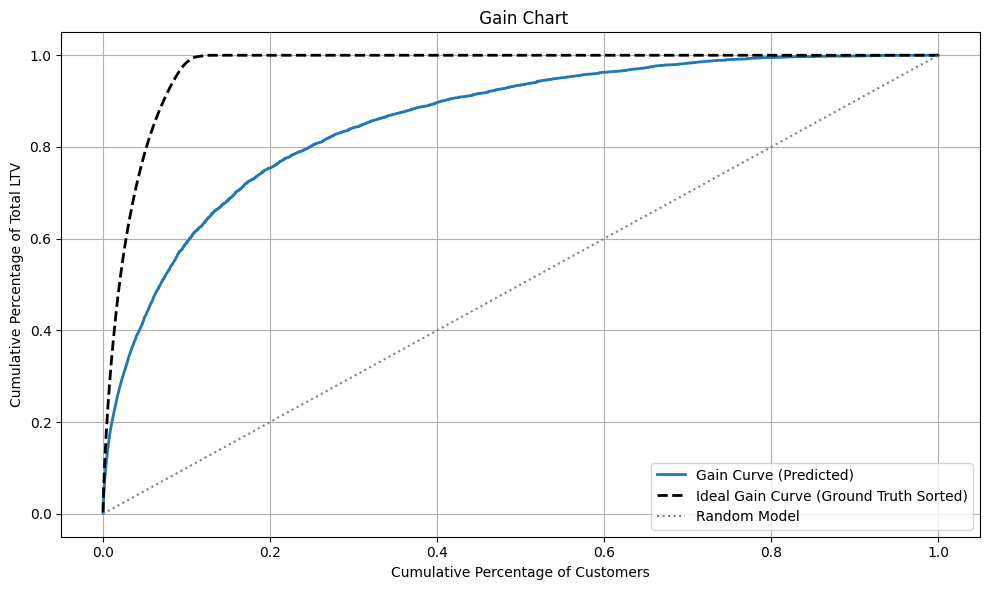

0.8583606880113821

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_area_under_gain_curve(pred_list, true_list, head_name=""):
    # 将零维张量列表转换为一维 NumPy 数组
    pred = pred_list.numpy()
    true = true_list.numpy()

    # 创建 DataFrame
    df = pd.DataFrame({'pred': pred, 'true': true})

    # 【1】预测值排序的增益曲线
    df_pred_sorted = df.sort_values(by='pred', ascending=False).copy()
    df_pred_sorted['cumulative_percentage_customers'] = np.arange(1, len(df_pred_sorted) + 1) / len(df_pred_sorted)
    df_pred_sorted['cumulative_percentage_ltv'] = df_pred_sorted['true'].cumsum() / df_pred_sorted['true'].sum()
    area_pred = np.trapz(df_pred_sorted['cumulative_percentage_ltv'],
                         df_pred_sorted['cumulative_percentage_customers'])

    # 【2】真实值排序的理想增益曲线（Ground Truth 理想线）
    df_true_sorted = df.sort_values(by='true', ascending=False).copy()
    df_true_sorted['cumulative_percentage_customers'] = np.arange(1, len(df_true_sorted) + 1) / len(df_true_sorted)
    df_true_sorted['cumulative_percentage_ltv'] = df_true_sorted['true'].cumsum() / df_true_sorted['true'].sum()
    area_true = np.trapz(df_true_sorted['cumulative_percentage_ltv'],
                         df_true_sorted['cumulative_percentage_customers'])

    # 【3】绘图
    plt.figure(figsize=(10, 6))
    plt.plot(df_pred_sorted['cumulative_percentage_customers'],
             df_pred_sorted['cumulative_percentage_ltv'],
             label="Gain Curve (Predicted)", linewidth=2)
    plt.plot(df_true_sorted['cumulative_percentage_customers'],
             df_true_sorted['cumulative_percentage_ltv'],
             label="Ideal Gain Curve (Ground Truth Sorted)",
             linestyle='--', color='black', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle=':', color='gray', label="Random Model")

    plt.xlabel('Cumulative Percentage of Customers')
    plt.ylabel('Cumulative Percentage of Total LTV')
    plt.title(f'{head_name} Gain Chart')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return area_pred

calculate_area_under_gain_curve(predict, true)

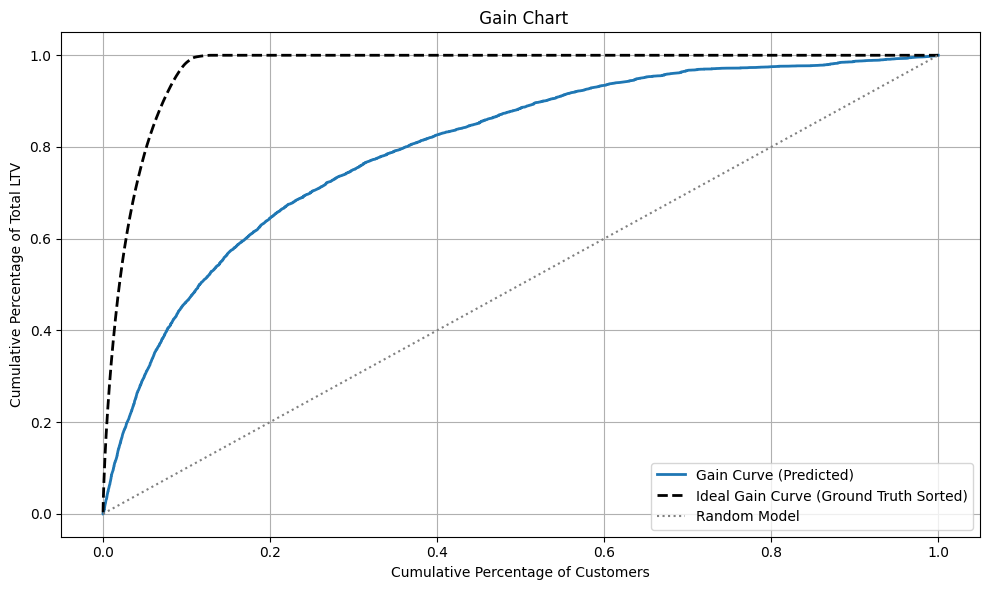

0.7994091230928211